# Model Agricultural Soil Moisture

In [77]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from das_util import next_power_of_2

data_dir='/fd1/QibinShi_data/England_farm/'
matplotlib.rcParams.update({'font.size': 16})

### data

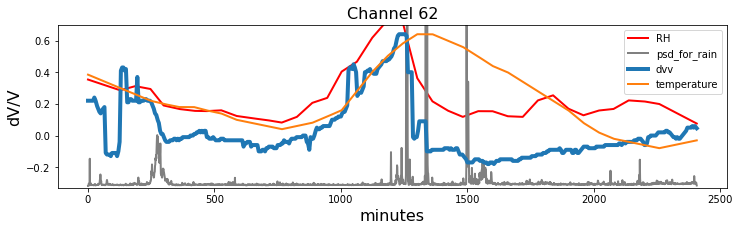

In [3]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    psd = f['psd_rain'][:]
    temp = f['temperature'][:]

s=moisture/100*2-1
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), 1-s, label='RH', color='r', lw=2)
plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
plt.ylim(-0.33, 0.7)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

,Plot,Treatments,tillage,Depth (cm),Dry Bulk density (g/cm3),Porosity (%),Moisture content (%),Rock volume (%),ind
0,1,STP Deep,25,10,1.29,51.28,13.61,2.36,35.0
3,2,LTP Deep,25,10,1.31,50.47,13.02,2.27,34.0
6,3,CTF Zero,0,10,1.22,53.98,14.56,3.55,33.0
9,4,CTF Zero,25,10,1.29,51.22,12.12,1.62,32.0
12,5,LTP Shallow,10,10,1.53,42.21,13.13,1.15,31.0


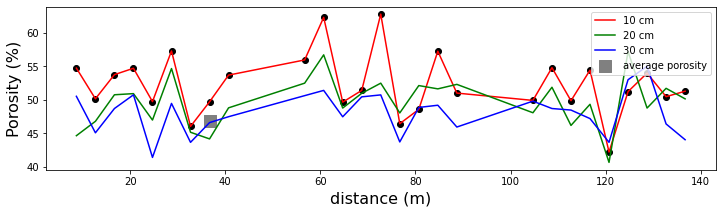

In [4]:
## read the soil physical parameters at different plots
phy_paras = pd.read_csv(data_dir + 'Soil_phy.csv')

## reverse the plot number, adding spare plots
phy_paras.loc[phy_paras['Plot'].between(1,9), 'ind'] = 36 - phy_paras.loc[phy_paras['Plot'].between(1,9), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(10,18), 'ind'] = 33 - phy_paras.loc[phy_paras['Plot'].between(10,18), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(19,27), 'ind'] = 30 - phy_paras.loc[phy_paras['Plot'].between(19,27), 'Plot']
phy_paras = phy_paras.loc[phy_paras['Plot'] < 28]

## split the data into different depths
phy_10cm = phy_paras.loc[phy_paras['Depth (cm)'] == 10]
phy_20cm = phy_paras.loc[phy_paras['Depth (cm)'] == 20]
phy_30cm = phy_paras.loc[phy_paras['Depth (cm)'] == 30]

## locate the plot near channel 62
plot_ind_for_ch62 = np.round((3.19 * 12 + 3.3) / 4 ).astype(int)
bulk_density_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
porosity_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100

bulk_density = (bulk_density_10cm+bulk_density_20cm+bulk_density_30cm)/3
porosity = (porosity_10cm+porosity_20cm+porosity_30cm)/3

## plot the porosity at different depths, plots and near the channel 62
plt.figure(figsize=(12, 3))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), color='k')
plt.scatter(plot_ind_for_ch62*4-3.3, porosity * 100, color='gray', s=150, marker='s', label='average porosity')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Porosity (%)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Porosity (%)']), label='30 cm', color='b')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Porosity (%)", fontsize = 16)
plt.legend() 

phy_10cm.head()

### Hydrological model

In [4]:
class hydro:
    def __init__(self, prec, porosity, s, T, I, till, tire, A_p, A_e, A_d):
        self.prec = prec
        self.s = (s-0.28)/0.62
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d

        ## evaporation
        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239
        self.pet = 1.6 * np.power((10*self.T / self.I), self.a)
        self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

        ## drainage
        self.drain = self.prec * self.s * self.till * self.tire  ## Drainage rate



    def get_s_rate(self):
        prec_rate = self.A_p * self.prec
        evap_rate = self.A_e * self.evap
        drain_rate = self.A_d * self.drain
        s_rate = prec_rate - evap_rate - drain_rate

        return s_rate, prec_rate, evap_rate, drain_rate, self.pet
        


### The evaporation slope

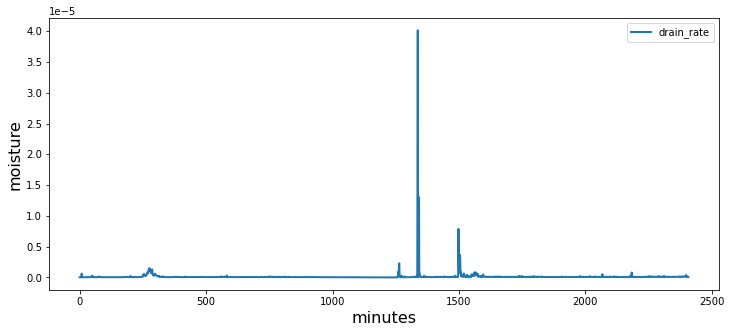

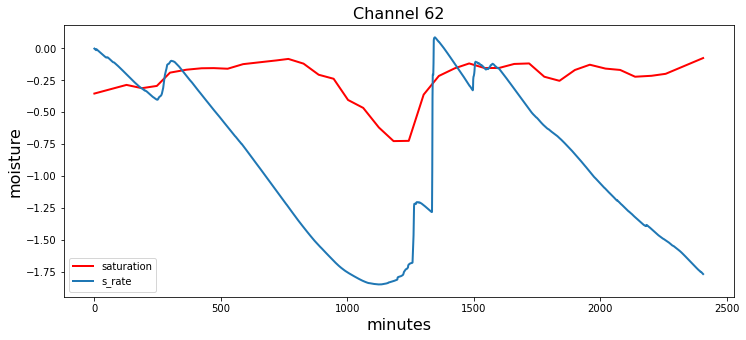

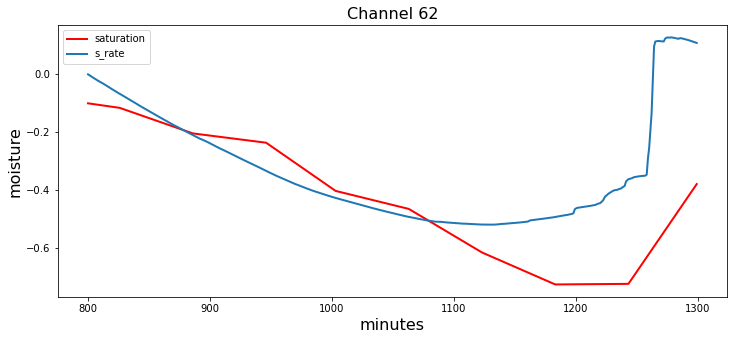

In [5]:
s_rate, prec_rate, evap_rate, drain_rate, pet = hydro(np.roll(psd, 1), porosity, s, temp, 12, 25, 7, 0.9,0.000003,0.0000005).get_s_rate()

plt.figure(figsize=(12, 5))
# plt.plot(np.arange(2408), (s-0.28)/0.62, label='kai', color='r', lw=2)
# plt.plot(np.arange(2408), np.roll(psd, 1), label='prec', color='b', lw=2)
# plt.plot(np.arange(2408), prec_rate, label='prec_rate', lw=2)
# plt.plot(np.arange(2408), evap_rate, label='evap_rate', lw=2)
plt.plot(np.arange(2408), drain_rate, label='drain_rate', lw=2)
# plt.plot(np.arange(2408), pet, label='pet', lw=2)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(2408), s-1, label='saturation', color='r', lw=2)
plt.plot(np.arange(2408), np.cumsum(s_rate), label='s_rate', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(500)+800, s[800:1300]-1, label='saturation', color='r', lw=2)
plt.plot(np.arange(500)+800, np.cumsum(s_rate[800:1300]), label='s_rate', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

### Hydrological model with only initial condition

In [6]:
class hydro0:
    def __init__(self, prec, porosity, s0, T, I, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history
        

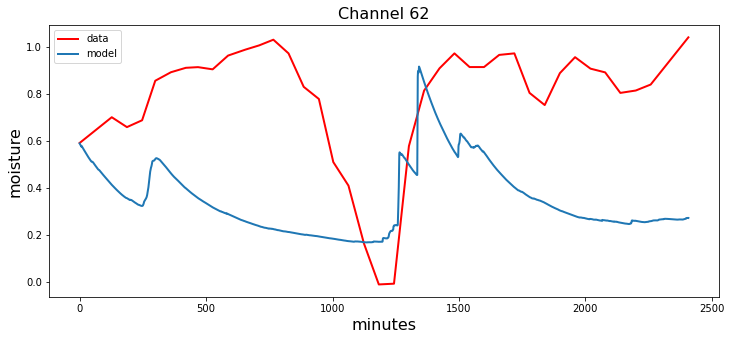

In [7]:
s_history = hydro0(np.roll(psd, 1), porosity, (s[0]-0.28)/0.62, temp, 12, 25, 7, 1,0.000003,0.0057).get_s_history()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(2408), (s-0.28)/0.62, label='data', color='r', lw=2)
plt.plot(np.arange(2408), s_history, label='model', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

### Hydrological model with initial saturation and surface moisture

In [8]:
class hydro0_sur:
    def __init__(self, prec, porosity, s0, s_sur, T, I, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.s_sur = s_sur
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s_sur[i] * self.till * self.tire   ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history

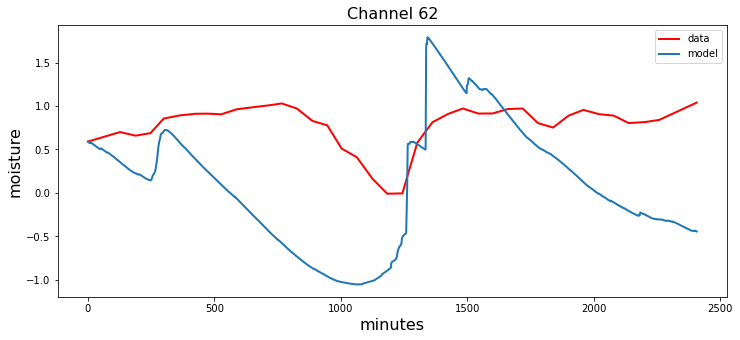

In [9]:
s_history = hydro0_sur(np.roll(psd, 1), porosity, (s[0]-0.28)/0.62, (s-0.28)/0.62, temp, 12, 25, 7, 2,0.000004,0.0057).get_s_history()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(2408), (s-0.28)/0.62, label='data', color='r', lw=2)
plt.plot(np.arange(2408), s_history, label='model', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

In [35]:
class hydro0_sur_piecewise:
    def __init__(self, prec, porosity, s0, s_sur, T, I, radiation, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.s_sur = s_sur
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.radiation = radiation
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s_sur[i] * self.till * self.tire * self.radiation[i]  ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history

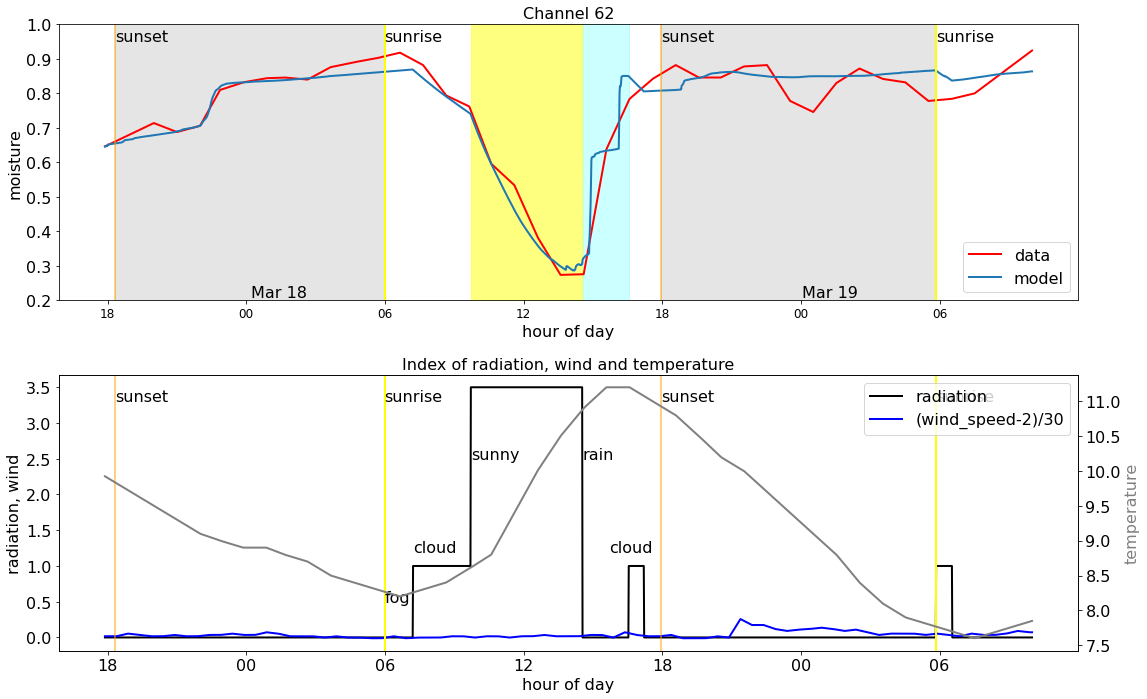

In [220]:
A_e = 0.000001
rad = np.zeros(2408)
rad[800:950] = 1
rad[950:1240] = 3.5
rad[1360:1400] = 1
rad[2158:2200] = 1


A_d = 0.0057
A_p = 1.0

ave_psd = np.zeros_like(psd)
for i in range(len(psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = psd[i] / 2
    else:
        ave_psd[i] = psd[i]

s_history = hydro0_sur_piecewise(ave_psd, porosity, s[0], s, temp, 9, rad+(wind_speed_interpolated-2)/30, 25, 7, A_p,A_e,A_d).get_s_history()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# First subplot
ax1.fill_between(np.arange(2408), 0, 1, where=rad > 1, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)

ax1.plot(np.arange(2408), s, label='data', color='r', lw=2)
ax1.plot(np.arange(2408), s_history, label='model', lw=2)
ax1.set_ylim(0.2, 1)
ax1.set_xlabel("hour of day", fontsize=16)
ax1.set_ylabel("moisture", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.set_title("Channel 62", fontsize=16)
ax1.legend()
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.text(27, 0.95, 'sunset', color='k')
ax1.text(726, 0.95, 'sunrise', color='k')
ax1.text(1443, 0.95, 'sunset', color='k')
ax1.text(2158, 0.95, 'sunrise', color='k')
ax1.text(Ind6hrs[1] + 20, 0.21, 'Mar 18', color='k')
ax1.text(Ind6hrs[5] + 30, 0.21, 'Mar 19', color='k')

# Second subplot
ax2.plot(np.arange(2408), rad, color='k', lw=2, label='radiation')
ax2.plot(np.arange(2408), (wind_speed_interpolated-2)/30, color='b', lw=2, label='(wind_speed-2)/30')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=16)
ax2.set_xlabel("hour of day", fontsize=16)
ax2.set_ylabel("radiation, wind", fontsize=16)
ax2.set_title("Index of radiation, wind and temperature", fontsize=16)
ax2.text(726, 0.5, 'fog', color='k')
ax2.text(800, 1.2, 'cloud', color='k')
ax2.text(950, 2.5, 'sunny', color='k')
ax2.text(1240, 2.5, 'rain', color='k')
ax2.text(1310, 1.2, 'cloud', color='k')
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(27, 3.3, 'sunset', color='k')
ax2.text(726, 3.3, 'sunrise', color='k')
ax2.text(1443, 3.3, 'sunset', color='k')
ax2.text(2158, 3.3, 'sunrise', color='k')
ax2.legend()

twinx = ax2.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')

twinx.set_ylabel("temperature", fontsize=16, color='gray')

plt.tight_layout()
plt.show()


In [41]:
acqu_time[800], acqu_time[950], acqu_time[1240], acqu_time[1360], \
      acqu_time[1500], acqu_time[1600], acqu_time[1680], acqu_time[1830], \
        acqu_time[2100], acqu_time[2220]  

(2023-03-18T07:34:00.000000Z,
 2023-03-18T10:04:00.000000Z,
 2023-03-18T14:57:00.000000Z,
 2023-03-18T16:58:00.000000Z,
 2023-03-18T19:18:00.000000Z,
 2023-03-18T21:01:00.000000Z,
 2023-03-18T22:21:00.000000Z,
 2023-03-19T00:51:00.000000Z,
 2023-03-19T05:22:00.000000Z,
 2023-03-19T07:22:00.000000Z)

In [8]:
csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False).dropna(axis='columns', how='all')
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()



with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0)
for i in range(len(ave_psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = ave_psd[i] / 2

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60

    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))



Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
for i in Ind6hrs:
    print(acqu_time[i])

2023-03-17T18:00:00.000000Z
2023-03-18T00:00:00.000000Z
2023-03-18T06:00:00.000000Z
2023-03-18T12:00:00.000000Z
2023-03-18T18:00:00.000000Z
2023-03-19T00:00:00.000000Z
2023-03-19T06:00:00.000000Z


Text(1443, 0.8, 'sunset')

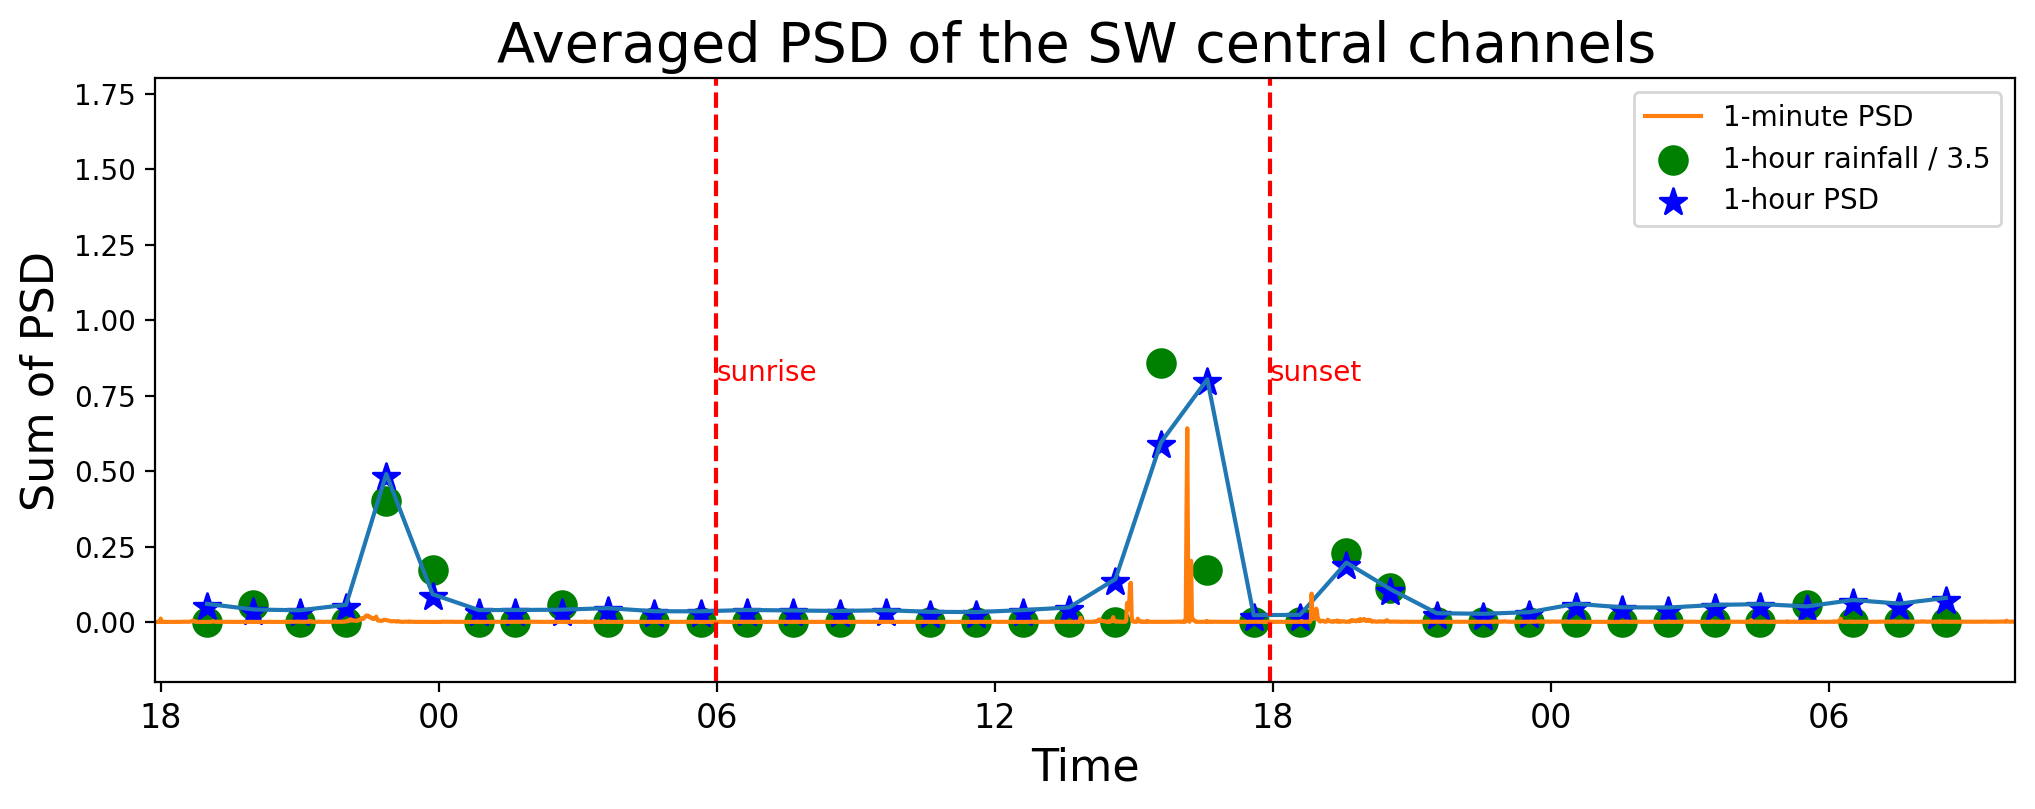

In [9]:
xax=np.arange(7, psd.shape[-1], 360)
tax=acqu_time[7:psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]
plt.figure(figsize = (12, 4), dpi = 200)   
plt.scatter(hourly_index, rain_diff/3.5, label='1-hour rainfall / 3.5', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd)-0.01, label='1-hour PSD', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(psd.shape[-1]), psd * A_p, label='1-minute PSD')
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Averaged PSD of the SW central channels ', fontsize = 20)  
plt.ylim(-0.2, 1.8)
plt.xlim(0, ave_psd.shape[-1])
plt.legend()

plt.axvline(x = 726, color = 'red', linestyle='--')
plt.axvline(x = 1443, color = 'red', linestyle='--')
plt.text(726, 0.8, 'sunrise', color='r')
plt.text(1443, 0.8, 'sunset', color='r')



In [217]:
csv_file = pd.read_csv('met_newport.csv')
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
time_stamps = csv_file['Time'].to_numpy()
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
wind_speed_interpolated.shape
acqu_time[2300]

2023-03-19T08:42:00.000000Z